In [1]:
import numpy as np
import matplotlib.pyplot as plt

from hnc_n_multiscale import  HNC_solver

# Two Species

Here we do QSP interactions between electrons and one ion type. 

Using $\tilde{r}\equiv r/r_s$, we implement potentials 
\begin{align}
\beta v_{ee}(\tilde{r}) &=  \frac{\Gamma_{ee}}{\tilde{r}}\left( 1- \exp[-\tilde{r} r_s/\Lambda_e]\right) +  \ln2 \exp\left[-\tilde{r}^2 r_s^2/(\pi \Lambda_e^2 \ln 2)\right]\\
\beta v_{ei}(\tilde{r}) &=  \frac{\Gamma_{ei}}{\tilde{r}}\left( 1- \exp[-\tilde{r} r_s/\Lambda_e]\right)\\
\beta v_{ii}(\tilde{r}) &=  \frac{\Gamma_{ii}}{\tilde{r}}
\end{align}
For  
\begin{align}
\Gamma_{ee}&=\frac{\beta e^2}{r_s}\\
\Gamma_{ei}&=\frac{\beta Z_i e^2}{r_s}\\
\Gamma_{ii}&=\frac{\beta Z_i^2 e^2}{r_s}\\
\end{align}

Define physical constants

In [2]:
# k_B = 1.380649e-23  # Boltzmann constant [J/K]
# hbar=  6.62607015e-34 # Planck [J/s]
eV = 0.0367512 # So 4 eV = 4 * 0.036.. in natural units
Kelvin = 8.61732814974493e-5*eV #Similarly, 1 Kelvin = 3.167e-6... in natural units 
π = np.pi
# [AU]
rs  = 3
T   = 1*eV 
Zstar=3

β   = 1/T
m_e = 1


Λe  = np.sqrt(  β*2*π /m_e )
Γee = β/rs 
Γei = -Zstar*β/rs 
Γii = Zstar**2*β/rs 
print(Γee, Γei, Γii)

9.069998621360211 -27.20999586408063 81.6299875922419


Plug into get potentials

In [3]:
def βvee(r):
#     return Γee/r*(1- np.exp(-r*rs/Λe))+ np.log(2) * np.exp(-r**2 * rs**2/( π*Λe**2*np.log(2)))
    return Γee/r*(1- np.exp(-r*rs/Λe))+ np.log(2) * np.exp(-4*np.pi* r**2 * rs**2/( Λe**2))

def βvei(r):
    return Γei/r*(1- np.exp(-r*rs/Λe))

def βvei_atomic(r):
    r_c = 3/5 #3/5 r_s in linear n_b(r) model
    return (Γei/r*np.heaviside(r - r_c,0.5)  )*  (1- np.exp(-r*rs/Λe))

# BAD SIMPLE
# def βvee(r):
#     return Γee/r


# def βvei(r):
#     return -Γei/r

def βvii(r):
    return Γii/r 

print(βvee(0.1), βvii(0.01))

2.745895947309204 8162.9987592241905


First, we initialize the hnc

In [23]:
N_species = 2
Gamma = np.array(  [[Γii,  Γei],
                    [Γei,  Γee]])


# Gamma = np.array(  [[50,  10],
#                     [10,  10]])

names = ["Ion-1", "Electron", ] 
kappa = 1
rho = np.array([  3/(4*np.pi), Zstar*3/(4*np.pi) ])
hnc2 = HNC_solver(N_species, Gamma=Gamma, kappa=kappa, tol=1e-4,
                 kappa_multiscale=5, rho = rho, num_iterations=int(1e4), 
                 R_max=20, N_bins=10000, names=names)


then we create the potential matrix, βu_matrix 

In [24]:
hnc2.βu_r_matrix[0,0] = βvii(hnc2.r_array)
hnc2.βu_r_matrix[1,0] = βvei(hnc2.r_array)
hnc2.βu_r_matrix[0,1] = βvei(hnc2.r_array)
hnc2.βu_r_matrix[1,1] = βvee(hnc2.r_array)


hnc2.split_βu_matrix()
hnc2.get_βu_k_matrices()

# i, j = hnc2.i, hnc2.j
# c_k = np.zeros((hnc2.N_species, hnc2.N_species, hnc2.N_bins))
# # c_k[i, j] = -4 * np.pi * hnc2.Gamma[i, j, np.newaxis] / (hnc2.k_array**2 + hnc2.kappa**2)[np.newaxis,np.newaxis,:]
# c_k[1, 1] =  -4 * np.pi * hnc2.Gamma[1, 1, np.newaxis] / (hnc2.k_array**2 + 1**2)[np.newaxis,np.newaxis,:]
# c_k[0, 0] =  -4 * np.pi * hnc2.Gamma[0, 0, np.newaxis] / (hnc2.k_array**2 )[np.newaxis,np.newaxis,:]
# c_k[0, 1] =  -4 * np.pi * hnc2.Gamma[0, 1, np.newaxis] / (hnc2.k_array**2 + 1**2 )[np.newaxis,np.newaxis,:]
# c_k[1, 0] =  -4 * np.pi * hnc2.Gamma[1, 0, np.newaxis] / (hnc2.k_array**2 + 1**2)[np.newaxis,np.newaxis,:]
# hnc2.c_k_matrix = c_k
# hnc2.c_s_k_matrix = hnc2.c_k_matrix + hnc2.βu_l_k_matrix
# hnc2.c_s_r_matrix = hnc2.FT_k_2_r_matrix(hnc2.c_s_k_matrix)
# hnc2.initialize_C_matrix()

/home/zach/plasma/hnc/hnc_n_multiscale.py:372: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_xlim(0,10)


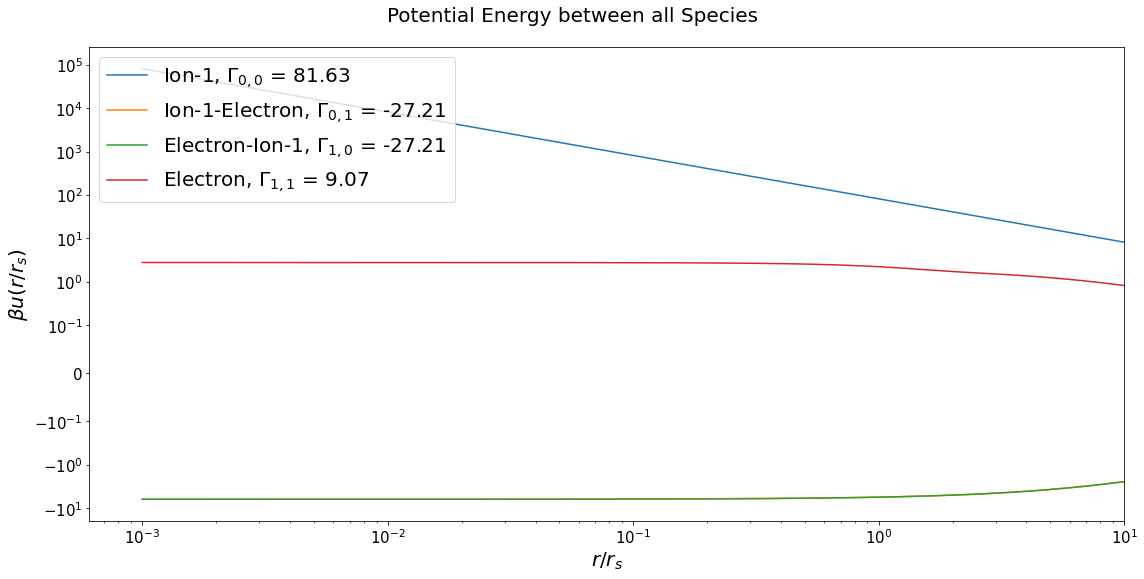

In [25]:
hnc2.plot_βu_all_species()

In [ ]:
hnc2.HNC_solve(alpha=0.01)
hnc2.plot_g_all_species()
hnc2.plot_species((1,1))

Err in c_r: 802.462
Err in c_r: 768.605
Err in c_r: 761.176
Err in c_r: 753.818
Err in c_r: 746.530
Err in c_r: 739.313
Err in c_r: 732.164
Err in c_r: 725.084
Err in c_r: 718.072
Err in c_r: 711.127
Err in c_r: 704.248
Err in c_r: 697.436
Err in c_r: 690.689
Err in c_r: 684.006
Err in c_r: 677.388
Err in c_r: 670.833
Err in c_r: 664.341
Err in c_r: 657.911
Err in c_r: 651.543
Err in c_r: 645.236
Err in c_r: 638.990
Err in c_r: 632.804
Err in c_r: 626.677
Err in c_r: 620.609
Err in c_r: 614.599
Err in c_r: 608.647
Err in c_r: 602.752
Err in c_r: 596.913
Err in c_r: 591.131
Err in c_r: 585.405
Err in c_r: 579.733
Err in c_r: 574.116
Err in c_r: 568.553
Err in c_r: 563.044
Err in c_r: 557.587
Err in c_r: 552.183
Err in c_r: 546.832
Err in c_r: 541.531
Err in c_r: 536.282
Err in c_r: 531.083
Err in c_r: 525.934
Err in c_r: 520.835
Err in c_r: 515.784
Err in c_r: 510.783
Err in c_r: 505.830
Err in c_r: 500.924
Err in c_r: 496.066
Err in c_r: 491.254
Err in c_r: 486.489
Err in c_r: 481.770


/home/zach/plasma/hnc/hnc_n_multiscale.py:190: RuntimeWarning: overflow encountered in exp
  self.h_r_matrix = -1 + np.exp(self.γs_r_matrix - self.βu_s_r_matrix) # 2. γ_r,u_s_r  -> h_r   (HNC)


Err in c_r: 86.784
Err in c_r: 161.186
Err in c_r: 194.069
Err in c_r: 79.818
Err in c_r: 1425.755
Err in c_r: 496.157
Err in c_r: 153.359
Err in c_r: 427.121
Err in c_r: 59.593
Err in c_r: 342.738
Err in c_r: 482.398
Err in c_r: 57.917
Err in c_r: 128.558
Err in c_r: 54.077
Err in c_r: 493.058
Err in c_r: 51.875
Err in c_r: 51.565
Err in c_r: 52.050
Err in c_r: 74.963
Err in c_r: 70.333
Err in c_r: 91.940
Err in c_r: 82.912
Err in c_r: 49.409
Err in c_r: 69.373
Err in c_r: 49.776
Err in c_r: 50.945
Err in c_r: 63.390
Err in c_r: 52.527
Err in c_r: 46.586
Err in c_r: 47.619
Err in c_r: 50.316
Err in c_r: 56.166
Err in c_r: 226.997
Err in c_r: 69.034
Err in c_r: 76.540
Err in c_r: 131.791
Err in c_r: 46.978
Err in c_r: 53.804
Err in c_r: 303.343
Err in c_r: 114.521
Err in c_r: 338.554
Err in c_r: 40.475
Err in c_r: 40.382
Err in c_r: 41.156
Err in c_r: 60.455
Err in c_r: 212.181
Err in c_r: 40.904
Err in c_r: 41.572
Err in c_r: 44.028
Err in c_r: 58.995
Err in c_r: 48.874
Err in c_r: 98

Err in c_r: 15.229
Err in c_r: 15.248
Err in c_r: 15.298
Err in c_r: 15.407
Err in c_r: 15.673
Err in c_r: 16.258
Err in c_r: 18.043
Err in c_r: 91.225
Err in c_r: 16.955
Err in c_r: 16.658
Err in c_r: 16.442
Err in c_r: 16.262
Err in c_r: 16.106
Err in c_r: 15.967
Err in c_r: 15.840
Err in c_r: 15.722
Err in c_r: 15.612
Err in c_r: 15.513
Err in c_r: 15.421
Err in c_r: 15.334
Err in c_r: 15.250
Err in c_r: 15.175
Err in c_r: 15.105
Err in c_r: 15.039
Err in c_r: 14.975
Err in c_r: 14.919
Err in c_r: 14.867
Err in c_r: 14.817
Err in c_r: 14.770
Err in c_r: 14.730
Err in c_r: 14.694
Err in c_r: 14.660
Err in c_r: 14.629
Err in c_r: 14.604
Err in c_r: 14.581
Err in c_r: 14.560
Err in c_r: 14.542
Err in c_r: 14.530
Err in c_r: 14.519
Err in c_r: 14.509
Err in c_r: 14.504
Err in c_r: 14.502
Err in c_r: 14.503
Err in c_r: 14.505
Err in c_r: 14.512
Err in c_r: 14.524
Err in c_r: 14.539
Err in c_r: 14.556
Err in c_r: 14.582
Err in c_r: 14.613
Err in c_r: 14.647
Err in c_r: 14.689
Err in c_r: 

Err in c_r: 2813.416
Err in c_r: 2788.110
Err in c_r: 2763.197
Err in c_r: 2738.666
Err in c_r: 2714.511
Err in c_r: 2690.715
Err in c_r: 2667.261
Err in c_r: 2644.140
Err in c_r: 2621.337
Err in c_r: 2598.849
Err in c_r: 2576.667
Err in c_r: 2554.781
Err in c_r: 2533.183
Err in c_r: 2511.861
Err in c_r: 2490.811
Err in c_r: 2470.022
Err in c_r: 2449.485
Err in c_r: 2429.190
Err in c_r: 2409.131
Err in c_r: 2389.304
Err in c_r: 2369.701
Err in c_r: 2350.323
Err in c_r: 2331.163
Err in c_r: 2312.207
Err in c_r: 2293.443
Err in c_r: 2274.869
Err in c_r: 2256.468
Err in c_r: 2238.240
Err in c_r: 2220.177
Err in c_r: 2202.281
Err in c_r: 2184.543
Err in c_r: 2166.948
Err in c_r: 2149.494
Err in c_r: 2132.172
Err in c_r: 2114.979
Err in c_r: 2097.894
Err in c_r: 2080.911
Err in c_r: 2064.007
Err in c_r: 2047.162
Err in c_r: 2030.353
Err in c_r: 2013.553
Err in c_r: 1996.732
Err in c_r: 1979.848
Err in c_r: 1962.810
Err in c_r: 1945.483
Err in c_r: 1927.631
Err in c_r: 1908.846
Err in c_r: 1

Err in c_r: 6684.747
Err in c_r: 6719.800
Err in c_r: 6765.600
Err in c_r: 6856.360
Err in c_r: 6099.122
Err in c_r: 6486.374
Err in c_r: 6506.093
Err in c_r: 6525.717
Err in c_r: 6545.348
Err in c_r: 6565.084
Err in c_r: 6585.027
Err in c_r: 6605.297
Err in c_r: 6626.028
Err in c_r: 6647.387
Err in c_r: 6669.612
Err in c_r: 6693.077
Err in c_r: 6718.501
Err in c_r: 6747.752
Err in c_r: 6789.270
Err in c_r: 7105.061
Err in c_r: 6666.196
Err in c_r: 6675.446
Err in c_r: 6684.485
Err in c_r: 6693.381
Err in c_r: 6702.196
Err in c_r: 6710.981
Err in c_r: 6719.775
Err in c_r: 6728.623
Err in c_r: 6737.552
Err in c_r: 6746.591
Err in c_r: 6755.765
Err in c_r: 6765.104
Err in c_r: 6774.637
Err in c_r: 6784.382
Err in c_r: 6794.364
Err in c_r: 6804.612
Err in c_r: 6815.150
Err in c_r: 6826.008
Err in c_r: 6837.213
Err in c_r: 6848.794
Err in c_r: 6860.784
Err in c_r: 6873.227
Err in c_r: 6886.165
Err in c_r: 6899.643
Err in c_r: 6913.702
Err in c_r: 6928.385
Err in c_r: 6943.732
Err in c_r: 6

Err in c_r: 23489.946
Err in c_r: 23550.735
Err in c_r: 23611.348
Err in c_r: 23671.784
Err in c_r: 23732.032
Err in c_r: 23792.092
Err in c_r: 23851.952
Err in c_r: 23911.612
Err in c_r: 23971.056
Err in c_r: 24030.273
Err in c_r: 24089.253
Err in c_r: 24147.991
Err in c_r: 24206.467
Err in c_r: 24264.666
Err in c_r: 24322.577
Err in c_r: 24380.184
Err in c_r: 24437.473
Err in c_r: 24494.410
Err in c_r: 24550.975
Err in c_r: 24607.129
Err in c_r: 24662.808
Err in c_r: 24717.964
Err in c_r: 24772.499
Err in c_r: 24826.276
Err in c_r: 24879.040
Err in c_r: 24930.436
Err in c_r: 24979.765
Err in c_r: 25025.660
Err in c_r: 25064.817
Err in c_r: 25086.848
Err in c_r: 25028.303
Err in c_r: 26128.251
Err in c_r: 25259.506
Err in c_r: 25374.838
Err in c_r: 25458.583
Err in c_r: 25526.090
Err in c_r: 25580.022
Err in c_r: 25612.544
Err in c_r: 25562.394
Err in c_r: 26740.707
Err in c_r: 25852.830
Err in c_r: 26200.814
Err in c_r: 26216.290
Err in c_r: 26230.282
Err in c_r: 26241.590
Err in c_r

Err in c_r: 22434.459
Err in c_r: 22473.214
Err in c_r: 22506.128
Err in c_r: 22529.900
Err in c_r: 22543.378
Err in c_r: 22544.332
Err in c_r: 22527.325
Err in c_r: 22476.311
Err in c_r: 22295.687
Err in c_r: 27743.329
Err in c_r: 25488.412
Err in c_r: 24924.311
Err in c_r: 24708.926
Err in c_r: 24606.070
Err in c_r: 24554.581
Err in c_r: 24530.260
Err in c_r: 24521.841
Err in c_r: 24523.392
Err in c_r: 24531.526
Err in c_r: 24544.138
Err in c_r: 24559.886
Err in c_r: 24577.851
Err in c_r: 24597.391
Err in c_r: 24618.049
Err in c_r: 24639.479
Err in c_r: 24661.417
Err in c_r: 24683.662
Err in c_r: 24706.049
Err in c_r: 24728.441
Err in c_r: 24750.714
Err in c_r: 24772.763
Err in c_r: 24794.490
Err in c_r: 24815.794
Err in c_r: 24836.572
Err in c_r: 24856.705
Err in c_r: 24876.061
Err in c_r: 24894.482
Err in c_r: 24911.764
Err in c_r: 24927.644
Err in c_r: 24941.747
Err in c_r: 24953.548
Err in c_r: 24962.238
Err in c_r: 24966.472
Err in c_r: 24963.821
Err in c_r: 24949.195
Err in c_r

Err in c_r: 3581.159
Err in c_r: 3604.667
Err in c_r: 3628.440
Err in c_r: 3651.142
Err in c_r: 3680.456
Err in c_r: 3701.966
Err in c_r: 3724.293
Err in c_r: 3747.028
Err in c_r: 3770.032
Err in c_r: 3793.236
Err in c_r: 3816.595
Err in c_r: 3840.077
Err in c_r: 3863.647
Err in c_r: 3887.289
Err in c_r: 3910.977
Err in c_r: 3934.699
Err in c_r: 3958.441
Err in c_r: 3982.189
Err in c_r: 4005.932
Err in c_r: 4029.659
Err in c_r: 4053.367
Err in c_r: 4077.048
Err in c_r: 4100.695
Err in c_r: 4124.301
Err in c_r: 4147.859
Err in c_r: 4171.365
Err in c_r: 4194.813
Err in c_r: 4218.196
Err in c_r: 4241.506
Err in c_r: 4264.730
Err in c_r: 4287.858
Err in c_r: 4310.881
Err in c_r: 4333.791
Err in c_r: 4356.580
Err in c_r: 4379.238
Err in c_r: 4401.753
Err in c_r: 4424.122
Err in c_r: 4446.340
Err in c_r: 4468.403
Err in c_r: 4490.307
Err in c_r: 4512.045
Err in c_r: 4533.617
Err in c_r: 4555.022
Err in c_r: 4576.260
Err in c_r: 4597.329
Err in c_r: 4618.226
Err in c_r: 4638.951
Err in c_r: 4

Err in c_r: 32105.922
Err in c_r: 35448.018
Err in c_r: 39630.480
Err in c_r: 45034.707
Err in c_r: 52335.395
Err in c_r: 62865.132
Err in c_r: 79758.256
Err in c_r: 112997.647
Err in c_r: 229038.167
Err in c_r: 203847.545
Err in c_r: 762501.859
Err in c_r: 8684.526
Err in c_r: 8736.974
Err in c_r: 8791.799
Err in c_r: 8849.519
Err in c_r: 8910.411
Err in c_r: 8974.710
Err in c_r: 9042.673
Err in c_r: 9114.542
Err in c_r: 9190.610
Err in c_r: 9271.197
Err in c_r: 9356.642
Err in c_r: 9447.310
Err in c_r: 9543.631
Err in c_r: 9646.068
Err in c_r: 9755.125
Err in c_r: 9871.363
Err in c_r: 9995.410
Err in c_r: 10127.948
Err in c_r: 10269.759
Err in c_r: 10421.724
Err in c_r: 10584.815
Err in c_r: 10760.125
Err in c_r: 10948.870
Err in c_r: 11152.433
Err in c_r: 11372.337
Err in c_r: 11610.370
Err in c_r: 11868.587
Err in c_r: 12149.317
Err in c_r: 12455.233
Err in c_r: 12789.401
Err in c_r: 13155.412
Err in c_r: 13557.439
Err in c_r: 14000.416
Err in c_r: 14490.210
Err in c_r: 15033.786
E

Err in c_r: 3766.930
Err in c_r: 3701.883
Err in c_r: 3632.150
Err in c_r: 3557.136
Err in c_r: 3476.107
Err in c_r: 3388.183
Err in c_r: 3292.278
Err in c_r: 3187.046
Err in c_r: 3070.815
Err in c_r: 2941.483
Err in c_r: 2796.387
Err in c_r: 2632.136
Err in c_r: 2444.471
Err in c_r: 2228.317
Err in c_r: 1978.664
Err in c_r: 1695.508
Err in c_r: 1406.813
Err in c_r: 1267.041
Err in c_r: 1715.383
Err in c_r: 3277.705
Err in c_r: 7641.917
Err in c_r: 48627.344
Err in c_r: 11476.300
Err in c_r: 12516.054
Err in c_r: 14234.465
Err in c_r: 17642.077
Err in c_r: 29829.955
Err in c_r: 13850.808
Err in c_r: 3329760.918
Err in c_r: 4266.844
Err in c_r: 4338.052
Err in c_r: 4413.289
Err in c_r: 4495.886
Err in c_r: 4609.866
Err in c_r: 4859.272
Err in c_r: 4678.757
Err in c_r: 4759.064
Err in c_r: 4838.688
Err in c_r: 4534.635
Err in c_r: 5686.685
Err in c_r: 5443.019
Err in c_r: 5247.075
Err in c_r: 4815.848
Err in c_r: 5269.211
Err in c_r: 5400.819
Err in c_r: 5422.913
Err in c_r: 5458.401
Err

Err in c_r: 4286.482
Err in c_r: 4572.506
Err in c_r: 4880.153
Err in c_r: 5207.546
Err in c_r: 5553.313
Err in c_r: 5916.451
Err in c_r: 6296.537
Err in c_r: 6693.618
Err in c_r: 7108.309
Err in c_r: 7541.802
Err in c_r: 7995.955
Err in c_r: 8473.373
Err in c_r: 8977.650
Err in c_r: 9513.519
Err in c_r: 10087.141
Err in c_r: 10706.577
Err in c_r: 11382.296
Err in c_r: 12128.033
Err in c_r: 12961.955
Err in c_r: 13908.423
Err in c_r: 15000.793
Err in c_r: 16285.833
Err in c_r: 17831.125
Err in c_r: 19738.080
Err in c_r: 22166.153
Err in c_r: 25381.574
Err in c_r: 29865.681
Err in c_r: 36587.341
Err in c_r: 47833.999
Err in c_r: 70421.400
Err in c_r: 119322.665
Err in c_r: 706205.503
Err in c_r: 120430.361
Err in c_r: 437908.795
Err in c_r: 66262.577
Err in c_r: 50592.160
Err in c_r: 39279.065
Err in c_r: 30411.324
Err in c_r: 22323.637
Err in c_r: 11683.409
Err in c_r: 22587.854
Err in c_r: 35692.794
Err in c_r: 32370.516
Err in c_r: 40589.521
Err in c_r: 32756.468
Err in c_r: 28693.55

Err in c_r: 9118.782
Err in c_r: 9124.419
Err in c_r: 9130.158
Err in c_r: 9136.001
Err in c_r: 9141.951
Err in c_r: 9148.014
Err in c_r: 9154.193
Err in c_r: 9160.492
Err in c_r: 9166.916
Err in c_r: 9173.473
Err in c_r: 9180.170
Err in c_r: 9187.012
Err in c_r: 9194.006
Err in c_r: 9201.157
Err in c_r: 9208.473
Err in c_r: 9215.965
Err in c_r: 9223.640
Err in c_r: 9231.507
Err in c_r: 9239.576
Err in c_r: 9247.856
Err in c_r: 9256.357
Err in c_r: 9265.092
Err in c_r: 9274.074
Err in c_r: 9283.314
Err in c_r: 9292.817
Err in c_r: 9302.583
Err in c_r: 9312.563
Err in c_r: 9322.446
Err in c_r: 9326.916
Err in c_r: 9353.532
Err in c_r: 9365.187
Err in c_r: 9377.230
Err in c_r: 9389.706
Err in c_r: 9402.656
Err in c_r: 9416.120
Err in c_r: 9430.145
Err in c_r: 9444.781
Err in c_r: 9460.085
Err in c_r: 9476.126
Err in c_r: 9492.979
Err in c_r: 9510.737
Err in c_r: 9529.512
Err in c_r: 9549.440
Err in c_r: 9570.688
Err in c_r: 9593.464
Err in c_r: 9618.038
Err in c_r: 9644.762
Err in c_r: 9

Err in c_r: 11463.769
Err in c_r: 11454.326
Err in c_r: 11444.892
Err in c_r: 11435.472
Err in c_r: 11426.069
Err in c_r: 11416.687
Err in c_r: 11407.330
Err in c_r: 11398.001
Err in c_r: 11388.705
Err in c_r: 11379.443
Err in c_r: 11370.221
Err in c_r: 11361.043
Err in c_r: 11351.906
Err in c_r: 11342.814
Err in c_r: 11333.771
Err in c_r: 11324.780
Err in c_r: 11315.845
Err in c_r: 11306.968
Err in c_r: 11298.152
Err in c_r: 11289.402
Err in c_r: 11280.722
Err in c_r: 11272.117
Err in c_r: 11263.590
Err in c_r: 11255.088
Err in c_r: 11246.395
Err in c_r: 11235.319
Err in c_r: 11238.825
Err in c_r: 11231.913
Err in c_r: 11224.876
Err in c_r: 11217.786
Err in c_r: 11210.690
Err in c_r: 11203.610
Err in c_r: 11196.563
Err in c_r: 11189.558
Err in c_r: 11182.602
Err in c_r: 11175.699
Err in c_r: 11168.852
Err in c_r: 11162.060
Err in c_r: 11155.325
Err in c_r: 11148.646
Err in c_r: 11142.024
Err in c_r: 11135.458
Err in c_r: 11128.946
Err in c_r: 11122.489
Err in c_r: 11116.084
Err in c_r

Err in c_r: 9929.138
Err in c_r: 9914.133
Err in c_r: 9902.219
Err in c_r: 9892.993
Err in c_r: 9886.183
Err in c_r: 9881.726
Err in c_r: 9879.327
Err in c_r: 9878.659
Err in c_r: 9879.416
Err in c_r: 9881.321
Err in c_r: 9884.123
Err in c_r: 9887.588
Err in c_r: 9891.519
Err in c_r: 9895.739
Err in c_r: 9900.094
Err in c_r: 9904.455
Err in c_r: 9908.716
Err in c_r: 9912.792
Err in c_r: 9916.619
Err in c_r: 9920.152
Err in c_r: 9923.359
Err in c_r: 9926.223
Err in c_r: 9928.743
Err in c_r: 9930.931
Err in c_r: 9932.808
Err in c_r: 9934.406
Err in c_r: 9935.767
Err in c_r: 9936.943
Err in c_r: 9938.003
Err in c_r: 9939.019
Err in c_r: 9940.081
Err in c_r: 9941.300
Err in c_r: 9942.809
Err in c_r: 9944.791
Err in c_r: 9947.468
Err in c_r: 9951.157
Err in c_r: 9956.314
Err in c_r: 9963.658
Err in c_r: 9974.426
Err in c_r: 9991.057
Err in c_r: 10019.624
Err in c_r: 10085.256
Err in c_r: 9992.774
Err in c_r: 10366.782
Err in c_r: 200117.584
Err in c_r: 1230.618
Err in c_r: 1887.537
Err in c

Err in c_r: 289.973
Err in c_r: 473.431
Err in c_r: 278.382
Err in c_r: 401.248
Err in c_r: 415.203
Err in c_r: 1193.628
Err in c_r: 354.796
Err in c_r: 1081.658
Err in c_r: 4128.709
Err in c_r: 387.418
Err in c_r: 381.575
Err in c_r: 429.761
Err in c_r: 488.495
Err in c_r: 549.390
Err in c_r: 617.596
Err in c_r: 685.392
Err in c_r: 741.812
Err in c_r: 894.503
Err in c_r: 868.883
Err in c_r: 932.265
Err in c_r: 979.123
Err in c_r: 1021.650
Err in c_r: 1093.673
Err in c_r: 1170.985
Err in c_r: 1268.788
Err in c_r: 1374.614
Err in c_r: 1502.456
Err in c_r: 1640.467
Err in c_r: 1808.218
Err in c_r: 1979.835
Err in c_r: 2189.930
Err in c_r: 2423.217
Err in c_r: 2695.610
Err in c_r: 3026.621
Err in c_r: 3448.671
Err in c_r: 4613.724
Err in c_r: 2495.059
Err in c_r: 3304.611
Err in c_r: 4246.980
Err in c_r: 5086.668
Err in c_r: 5942.404
Err in c_r: 6892.561
Err in c_r: 8208.508
Err in c_r: 9714.519
Err in c_r: 12359.782
Err in c_r: 15334.033
Err in c_r: 22537.837
Err in c_r: 33056.808
Err in

In [ ]:
hnc2.get_γs_k_matrix()
hnc2.γs_r_matrix = hnc2.FT_k_2_r_matrix(hnc2.γs_k_matrix)
hnc2.γs_r_matrix[1,1]

In [ ]:
# print(hnc.c_r_matrix)

h_r_matrix = hnc2.h_r_matrix
c_r_matrix = hnc2.c_r_matrix

# To get the radial distribution function g(r), you can add 1 to the h_r_matrix:
g_r_matrix = h_r_matrix + 1

# To visualize the results, you can use matplotlib to plot the g(r) function:
# hnc2.plot_species((0,0))
# hnc2.plot_species_convergence((0,0))
hnc2.plot_g_all_species()

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

# MM_r, MM_g = np.loadtxt("/home/zach/plasma/atomic_forces/average_atom/jupyter/Murillo_HNC.txt").T
# ax.plot(MM_r[::3], MM_g[::3], 'k.', label="MM HNC- One Species")
# ax.plot(hnc.r_array, hnc.h_r_matrix[0,0]+1, label="One Species")
ax.plot(hnc2.r_array, hnc2.h_r_matrix[0,0]+1,'--.', label="Two Species")
ax.set_ylabel(r'$g(r/r_s)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)
ax.set_ylim(-0.1,3)
ax.set_xlim(0,5)
ax.tick_params(labelsize=15)
ax.legend(fontsize=15)

# Effective Potentials

In [ ]:
# fig, ax = plt.subplots()

# ax.plot(hnc2.r_array, 1+hnc2.heff_r_matrix[0,0],label= 'h')
# ax.plot(hnc2.r_array, hnc2.ceff_r_matrix[0,0],label='c')
# ax.plot(hnc2.r_array,np.log(1+hnc2.heff_r_matrix)[0,0],label='log(1+h)')
# ax.set_yscale('symlog',linthresh=1e-5)
# ax.set_xlim(1e-1,2)
# # ax.set_xscale('log')
# ax.legend()

In [ ]:
hnc2.invert_HNC( 1)

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(hnc2.r_array, hnc2.βueff_r_matrix[0,0], label="Effective")
ax.plot(hnc2.r_array, hnc2.βu_r_matrix[0,0], label="Initial")
ax.set_ylabel(r'$\beta u(r/r_s)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)
ax.set_ylim(-1e1,1e6)
ax.set_yscale('symlog',linthresh=1)
ax.tick_params(labelsize=15)
ax.legend(fontsize=15)

In [ ]:
(1+hnc2.heff_r_matrix)/np.exp(hnc2.heff_r_matrix -hnc2.ceff_r_matrix  - hnc2.βueff_r_matrix  )

In [ ]:
hnc2.βueff_r_matrix/ ( hnc2.heff_r_matrix + hnc2.ceff_r_matrix - np.log(1+hnc2.heff_r_matrix))

# Check!

In [ ]:
N_species = 1
Gamma = np.array(  [[1]])
names = ["Ion Effective"] 
kappa = 1
rho = np.array([3/(4*np.pi)])
hnc_check = HNC_solver(N_species, Gamma=Gamma, kappa=kappa, tol=1e-3, kappa_multiscale=1,
                       rho = rho, num_iterations=int(1e4), R_max=10, N_bins=1000, names=names)
hnc_check.βu_r_matrix = np.nan_to_num( hnc2.βueff_r_matrix,nan = -np.log(1.e-16), posinf=-np.log(1e-16) ).copy()
hnc_check.split_βu_matrix()
hnc_check.get_βu_k_matrices()

hnc_check.HNC_solve()


In [ ]:
hnc2.ceff_k_matrix

In [ ]:
ieff, jeff = slice(None, hnc2.Neff_species), slice(None,hnc2.Neff_species)

I_plus_h_rho_inverse = hnc2.invert_matrix(hnc2.I[ieff, jeff,np.newaxis] + hnc2.heff_k_matrix[ieff,jeff]*hnc2.rhoeff[ieff,np.newaxis,np.newaxis])
I_plus_h_rho_inverse
hnc2.A_times_B(I_plus_h_rho_inverse, hnc2.heff_k_matrix)

In [ ]:
((hnc2.heff_r_matrix+1)/np.exp(-hnc2.βueff_r_matrix + hnc2.heff_r_matrix - hnc2.ceff_r_matrix))

In [ ]:
np.array([hnc_check.r_array, hnc_check.βu_r_matrix[0,0]])

In [ ]:
hnc2.heff_k_matrix

In [ ]:
hnc2.ceff_r_matrix

In [ ]:
np.savetxt("example_veff_1eV_rs_3aBohr.txt", np.array([hnc_check.r_array, hnc_check.βu_r_matrix[0,0]]).T,header="r/r_s,   beta v_ii^eff   (both unitless)",delimiter=', ' )

In [ ]:
hnc_check.plot_g_all_species()

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(hnc2.r_array, hnc2.h_r_matrix[0,0]+1,'.', label="Two Actual Species")
ax.plot(hnc_check.r_array, hnc_check.h_r_matrix[0,0]+1,'-', label="One Effective Species")
ax.set_ylabel(r'$g(r/r_s)$',fontsize=20)
ax.set_xlabel(r'$r/r_s$',fontsize=20)
ax.set_ylim(-0.1,3)
ax.set_xlim(0,5)
ax.tick_params(labelsize=15)
ax.legend(fontsize=15)